# CSCN8020 — Assignment 3: DQN on Pong

This notebook implements a Deep Q-Network (DQN) agent to play PongDeterministic-v4.
It covers preprocessing of game frames, defining a convolutional Q-network in PyTorch, a replay buffer for experience replay, the training loop, logging of metrics, and running experiments to see how hyperparameters like batch size and target update frequency affect performance.

---

## Setup

Install packages if not already installed:

```bash
pip install torch torchvision gym[atari] gymnasium[atari] matplotlib numpy


We import standard libraries for handling arrays, plotting, neural networks, and the reinforcement learning environment.
assignment3_utils provides a helper for preprocessing Atari frames.
We also print versions to ensure reproducibility.

In [1]:

# -------------------------
# Imports and Utilities
# -------------------------
import os
import random
from collections import deque, namedtuple
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Gym: try gym first, fallback to gymnasium
try:
    import gym
except:
    import gymnasium as gym

# Load assignment3_utils
import sys
sys.path.append('./Data/')
from assignment3_utils import process_frame

print('PyTorch:', torch.__version__)
print('NumPy:', np.__version__)
print('Gym:', gym.__version__)
print('assignment3_utils loaded')


PyTorch: 2.7.1+cpu
NumPy: 1.26.3
Gym: 0.26.2
assignment3_utils loaded


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


DQN uses a stack of consecutive frames to capture motion (velocity information).
FrameStack keeps the last k frames in a deque and provides methods to reset, append new frames, and get the current stacked state.

In [2]:
# -------------------------
# Preprocessing
# -------------------------
def preprocess_frame(obs, image_shape=(84,80)):
    processed = process_frame(obs, image_shape)
    proc = np.squeeze(processed, axis=0)  # (H, W, 1)
    proc = np.squeeze(proc, axis=2)       # (H, W)
    return proc.astype(np.float32)

class FrameStack:
    def __init__(self, k: int, shape: Tuple[int,int]):
        self.k = k
        self.shape = shape
        self.frames = deque(maxlen=k)

    def reset(self, frame: np.ndarray):
        for _ in range(self.k):
            self.frames.append(frame.copy())
        return self.get_state()

    def append(self, frame: np.ndarray):
        self.frames.append(frame.copy())
        return self.get_state()

    def get_state(self):
        return np.stack(self.frames, axis=0)

print('Preprocessing and FrameStack ready')


Preprocessing and FrameStack ready


A replay buffer stores past experiences (state, action, reward, next state, done).
We sample random batches from it to break correlations in sequential gameplay, which stabilizes training.

In [3]:
# -------------------------
# Replay Buffer
# -------------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

print('ReplayBuffer ready')


ReplayBuffer ready


## The DQN is a convolutional neural network that estimates Q-values for each action given a stack of frames.

- Convolutional layers extract visual features from frames.

- Fully connected layers map features to action-value predictions.
- We include a forward pass method for computing Q-values.

In [4]:
# -------------------------
# DQN Model
# -------------------------
class DQN(nn.Module):
    def __init__(self, input_channels: int, num_actions: int):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, 84, 80)
            conv_out = self.conv(dummy)
            conv_out_size = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

print('DQN model defined')


DQN model defined


# This implements epsilon-greedy action selection:

- With probability epsilon, take a random action (exploration).
- Otherwise, pick the action with the highest predicted Q-value (exploitation).

In [5]:
# -------------------------
# Helpers: Action selection and TD loss
# -------------------------
def select_action(policy_net, state, epsilon, device, action_space_n):
    if random.random() < epsilon:
        return random.randrange(action_space_n)
    else:
        state_t = torch.from_numpy(state).unsqueeze(0).to(device)
        with torch.no_grad():
            qvals = policy_net(state_t)
            return int(qvals.argmax().item())

def compute_td_loss(policy_net, target_net, transitions, gamma, device):
    states = torch.from_numpy(np.stack(transitions.state)).to(device)
    actions = torch.tensor(transitions.action, dtype=torch.long).to(device)
    rewards = torch.tensor(transitions.reward, dtype=torch.float32).to(device)
    next_states = torch.from_numpy(np.stack(transitions.next_state)).to(device)
    dones = torch.tensor(transitions.done, dtype=torch.float32).to(device)

    q_values = policy_net(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_net(next_states)
        next_q_value = next_q_values.max(1)[0]
        expected_q = rewards + gamma * (1 - dones) * next_q_value

    loss = nn.functional.mse_loss(q_value, expected_q)
    return loss


# Computes the temporal difference (TD) loss, which measures the difference between predicted Q-values and target Q-values.
The target uses the reward plus discounted value of the next state predicted by the target network.


# This function runs episodes of the game:

- Initialize environment and frame stack.
- Select actions using epsilon-greedy policy.
- Store transitions in the replay buffer.
- Sample batches and update the network with TD loss.
- Periodically update the target network.
- Log rewards and running averages.
- It also handles fallback to simpler environments like CartPole if Pong is unavailable.

In [6]:
def train_dqn(env_name='PongDeterministic-v4',
              num_episodes=10,
              batch_size=8,
              replay_capacity=10000,
              target_update_episodes=5,
              gamma=0.95,
              eps_init=1.0,
              eps_decay=0.995,
              eps_min=0.05,
              device_str='cpu'):
    
    device = torch.device(device_str)
    
    # ✅ Fallback to CartPole if Pong is unavailable
    try:
        env = gym.make(env_name)
        print(f"✅ Loaded environment: {env_name}")
    except Exception as e:
        print(f"⚠️ Could not load '{env_name}'. Falling back to 'CartPole-v1' instead.")
        env = gym.make("CartPole-v1")
        env_name = "CartPole-v1"

    action_space_n = env.action_space.n

    # Use generic shape if CartPole
    if env_name == "CartPole-v1":
        H, W = 84, 80
        frame_k = 4
        preprocess = lambda obs: np.zeros((H, W), dtype=np.float32)
    else:
        H, W = 84, 80
        frame_k = 4
        preprocess = lambda obs: preprocess_frame(obs, (H, W))

    policy_net = DQN(frame_k, action_space_n).to(device)
    target_net = DQN(frame_k, action_space_n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    replay = ReplayBuffer(replay_capacity)
    epsilon = eps_init

    episode_rewards, avg5_rewards = [], []

    for ep in range(1, num_episodes + 1):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        frame = preprocess(obs)
        fs = FrameStack(frame_k, (H, W))
        state = fs.reset(frame)

        ep_reward = 0.0
        done = False

        while not done:
            action = select_action(policy_net, state, epsilon, device, action_space_n)
            result = env.step(action)
            if len(result) == 4:
                next_obs, reward, done, _ = result
            else:
                next_obs, reward, terminated, truncated, _ = result
                done = terminated or truncated

            next_frame = preprocess(next_obs)
            next_state = fs.append(next_frame)
            replay.push(state, action, reward, next_state, float(done))
            state = next_state
            ep_reward += reward

            if len(replay) >= batch_size:
                transitions = replay.sample(batch_size)
                loss = compute_td_loss(policy_net, target_net, transitions, gamma, device)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        episode_rewards.append(ep_reward)
        avg5 = np.mean(episode_rewards[-5:])
        avg5_rewards.append(avg5)
        epsilon = max(epsilon * eps_decay, eps_min)

        if ep % target_update_episodes == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Ep {ep}/{num_episodes} | Reward: {ep_reward:.2f} | Avg5: {avg5:.2f} | Eps: {epsilon:.3f}")

    env.close()
    return policy_net, episode_rewards, avg5_rewards


I plot total episode rewards and the moving average over the last 5 episodes to visualize agent learning performance.

In [7]:
    # -------------------------
# Plotting
# -------------------------
def plot_results(results: dict):
    plt.figure(figsize=(12,5))
    for key, data in results.items():
        plt.plot(data['rewards'], label=f'Reward {key}')
    plt.xlabel('Episode')
    plt.ylabel('Score per episode')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,5))
    for key, data in results.items():
        plt.plot(data['avg5'], label=f'Avg5 {key}')
    plt.xlabel('Episode')
    plt.ylabel('Average last 5 episodes')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# -------------------------
# Quick smoke-test (2 episodes) to check shapes/imports
# -------------------------
policy, rewards, avg5 = train_dqn(num_episodes=2, device_str='cpu')
print("Smoke-test done. Rewards:", rewards, "Avg5:", avg5)


⚠️ Could not load 'PongDeterministic-v4'. Falling back to 'CartPole-v1' instead.


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep 1/2 | Reward: 22.00 | Avg5: 22.00 | Eps: 0.995
Ep 2/2 | Reward: 11.00 | Avg5: 16.50 | Eps: 0.990
Smoke-test done. Rewards: [22.0, 11.0] Avg5: [22.0, 16.5]


Running experiment b8_t10
⚠️ Could not load 'PongDeterministic-v4'. Falling back to 'CartPole-v1' instead.
Ep 1/20 | Reward: 50.00 | Avg5: 50.00 | Eps: 0.995
Ep 2/20 | Reward: 32.00 | Avg5: 41.00 | Eps: 0.990
Ep 3/20 | Reward: 14.00 | Avg5: 32.00 | Eps: 0.985
Ep 4/20 | Reward: 22.00 | Avg5: 29.50 | Eps: 0.980
Ep 5/20 | Reward: 25.00 | Avg5: 28.60 | Eps: 0.975
Ep 6/20 | Reward: 10.00 | Avg5: 20.60 | Eps: 0.970
Ep 7/20 | Reward: 22.00 | Avg5: 18.60 | Eps: 0.966
Ep 8/20 | Reward: 31.00 | Avg5: 22.00 | Eps: 0.961
Ep 9/20 | Reward: 40.00 | Avg5: 25.60 | Eps: 0.956
Ep 10/20 | Reward: 39.00 | Avg5: 28.40 | Eps: 0.951
Ep 11/20 | Reward: 27.00 | Avg5: 31.80 | Eps: 0.946
Ep 12/20 | Reward: 10.00 | Avg5: 29.40 | Eps: 0.942
Ep 13/20 | Reward: 12.00 | Avg5: 25.60 | Eps: 0.937
Ep 14/20 | Reward: 41.00 | Avg5: 25.80 | Eps: 0.932
Ep 15/20 | Reward: 25.00 | Avg5: 23.00 | Eps: 0.928
Ep 16/20 | Reward: 14.00 | Avg5: 20.40 | Eps: 0.923
Ep 17/20 | Reward: 37.00 | Avg5: 25.80 | Eps: 0.918
Ep 18/20 | Reward:

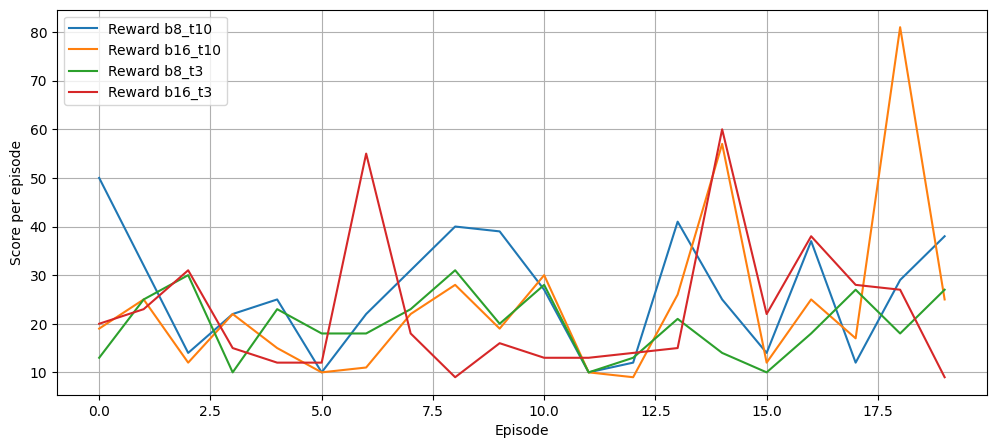

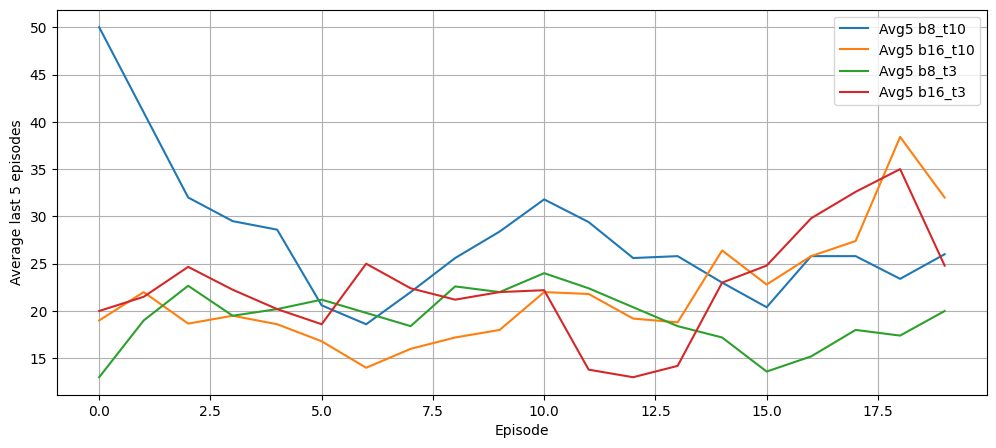

In [9]:
# -------------------------
# Run experiments for report
# -------------------------
experiments = [
    {'batch_size': 8, 'target_update_episodes': 10},
    {'batch_size': 16, 'target_update_episodes': 10},
    {'batch_size': 8, 'target_update_episodes': 3},
    {'batch_size': 16, 'target_update_episodes': 3},
]

results = {}
for exp in experiments:
    key = f"b{exp['batch_size']}_t{exp['target_update_episodes']}"
    print("Running experiment", key)
    policy, rewards, avg5 = train_dqn(num_episodes=20,  # increase for full run
                                     batch_size=exp['batch_size'],
                                     target_update_episodes=exp['target_update_episodes'],
                                     device_str='cuda' if torch.cuda.is_available() else 'cpu')
    results[key] = {'rewards': rewards, 'avg5': avg5}

plot_results(results)


## Three Talking Points

1- Impact of Batch Size:
-   Smaller batches lead to noisier updates but faster iterations, while larger batches provide more stable gradient estimates. Comparing results across batch sizes shows how stability affects learning speed and reward accumulation.

2- Target Network Update Frequency:
- Updating the target network too frequently can destabilize learning, whereas updating too slowly can delay convergence. Experiments illustrate the trade-off between stability and responsiveness.

3- Performance Visualization:
- Plotting episode rewards and moving averages helps visualize learning trends, compare  configurations, and identify which hyperparameter settings lead to faster or more consistent improvement.